## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.optimize import minimize


import h5py
from scipy.stats import chi2
import pickle
import pandas as pd

import seaborn as sns

from observation_data.observations import *


/Users/nolansmyth/opt/anaconda3/envs/kinetic_recoupling/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
A_recs = [1e11, 1e12, 1e14]
kk = np.logspace(-4, 2, 500)
ktoev = 8.6173e-5


In [4]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
sns.set_palette("colorblind")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

In [66]:
# pk_sd_interp = pickle.load(open("interps/pks_sd_interp.p", "rb"))
pk_sd_interp = pickle.load(open("interps/pks_sd_interp_n2.p", "rb"))

best_fits_saved = np.load("./interps/best_fit_sds.npz")
#! need to redo best_fits_n2.py. All the a values are the same now
# best_fits_saved = np.load("./interps/best_fit_sds_n2.npz")
best_a_dimless_arr = best_fits_saved["best_a_dimless_arr"]

pk_strong_interp_n2 = pickle.load(open("interps/pks_strong_interp_n2.p", "rb"))

pk_no_rec_interp = pickle.load(open("interps/pk_no_rec_interp.p", "rb"))
Pks_no_rec = pk_no_rec_interp(kk)

pk_delta_dict = pickle.load(open("interps/pk_delta_dict.p", "rb"))
rate_over_hubble_dict = pickle.load(open("interps/rate_over_hubble_dict.p", "rb"))

In [6]:
def scientific_format(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"${} \times 10^{{{}}}$".format(mantissa, int(exponent))

### Delta Recoupling Figures

In [7]:
def plot_delta_recoupling_rate():
    taus = np.logspace(-2, np.log10(1.4e4), 10000)
    for i, A_rec in reversed(list(enumerate(A_recs))):
        rate_over_hubble_interp = rate_over_hubble_dict[A_rec]
        plt.plot(
            taus,
            rate_over_hubble_interp(taus),
            label="A_rec = " + scientific_format(A_rec),
        )

    plt.plot([1e-3, 1e10], [1, 1], "k--")
    plt.plot([1e-3, 1e10], [1e-3, 1e-3], "k:")
    plt.plot([1e-3, 1e10], [1e3, 1e3], "k:")

    plt.xlim(2e-1, 2e-0)
    plt.ylim(1e-8, 1e8)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("$\\tau$ [Mpc]", fontsize=16)

    plt.ylabel("$\Gamma_{\mathrm{DM-DR}} / \mathcal{H}$", fontsize=16)
    plt.title("Comoving Scattering Rate")
    plt.legend()
    plot_dir = "Figures/"
    filename = "Scattering_rate_delta.pdf"
    # plt.savefig(plot_dir + filename)
    # plt.clf()
    plt.show()

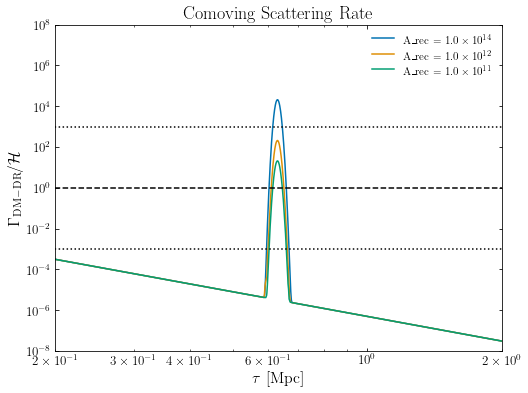

In [8]:
plot_delta_recoupling_rate()

In [9]:
def plot_delta_power_spectrum():
    lines = ["-", "--", "-."]
    for i, A_rec in reversed(list(enumerate(A_recs))):
        Pk_delta = pk_delta_dict[A_rec](kk)
        plt.plot(
            kk,
            Pk_delta / Pks_no_rec,
            ls=lines[i % len(lines)],
            label="A_rec = " + scientific_format(A_rec),
        )

    plt.plot(kk, Pks_no_rec / Pks_no_rec, "--", label="No Rec")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("$k \mathrm{[h ~Mpc}^{-1}]$")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.title("Matter Power Spectrum")
    plt.xlim(1, 1e2)
    plt.ylim(1e-3, 2)
    plt.legend()
    plot_dir = "Figures/"
    filename = "delta_power_spectrum.pdf"
    # plt.savefig(plot_dir + filename)
    # plt.clf()
    plt.show()

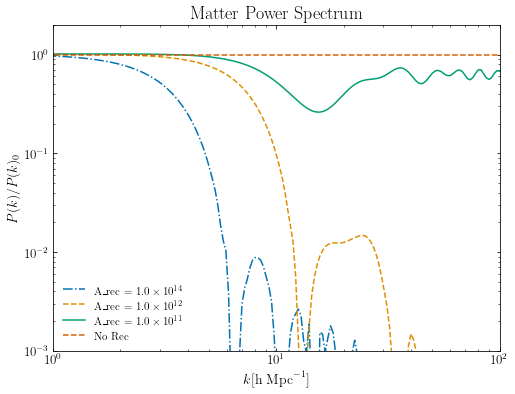

In [10]:
plot_delta_power_spectrum()

### Varied Recoupling Plots

In [11]:
a_idm_dr=1e1
nindex_idm_dr=2
omega0_cdm=0.12038
f_idm_dr=1.0
h=0.67556
xi_idr=0.3

def dmu_idm_dr(
    T_rec,
    A_rec,
    z,
    case="recoupling",
    a_idm_dr=a_idm_dr,
    nindex_idm_dr=nindex_idm_dr,
    omega0_cdm=omega0_cdm,
    f_idm_dr=f_idm_dr,
    h=h,
    xi=xi_idr,
    ):
    """
    Calculate the comoving scattering rate for a given T_rec, A_rec, z.
    """
    base_rate = (
        a_idm_dr * ((1 + z) / (1e7)) ** nindex_idm_dr * omega0_cdm * f_idm_dr * h**2
    )
    T_idr = 2.7255 * xi

    # This is for a phase transition like scenario, not a delta function
    if case == "recoupling":
        if T_rec > T_idr * (1 + z):
            return base_rate * (1 + A_rec)

    return base_rate

def plot_varied_recoupling(Tr1, Tr2, Ar1, Ar2, num_interps=7, save=False):
    """
    Plot the interpolation between two scenarios with varied
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """
    
    zs = np.logspace(5, 8, 1000)
    # dmus1 = [dmu_idm_dr(Tr1, Ar1, z, a_idm_dr = 1e1, nindex_idm_dr=2) for z in zs]
    # dmus2 = [dmu_idm_dr(Tr2, Ar2, z, a_idm_dr = 1e1, nindex_idm_dr=2) for z in zs]
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z) for z in zs]
    dmus2 = [dmu_idm_dr(Tr2, Ar2, z) for z in zs]

    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    plt.plot(
        kk,
        1 - (pk_strong_interp_n2((Tr1, Ar1, kk)) / Pks_no_rec),
        # "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    plt.plot(
        kk,
        1 - (pk_strong_interp_n2((Tr2, Ar2, kk)) / Pks_no_rec),
        # "r",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr2 * ktoev), scientific_format(Ar2)),
    )
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e0, 1e2)
    plt.ylim(1e-1, 2e0)
    plt.xlabel("$k$ [$\mathrm{h}$ $\mathrm{Mpc}^{-1}$]")
    plt.ylabel("$1 - \Delta/\Delta_0$")
    plt.legend(loc="upper left")
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")
    plt.plot(
        zs,
        dmus1,
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    plt.plot(
        zs,
        dmus2,
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr2 * ktoev), scientific_format(Ar2)),
    )
    plt.plot(np.logspace(5, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(5, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])

    plt.legend(loc="upper left")
    fig.tight_layout(h_pad=2)

    if save:
        plot_dir = "Figures/"
        filename = "varying_recoupling_{:.1e}{:.1e}{:.1e}{:.1e}.pdf".format(
            Tr1, Ar1, Tr2, Ar2
        )

        plt.savefig(plot_dir + filename)
        plt.clf()
    else:
        plt.show()

In [12]:
N_points = 100
T_rec_strong_arr = np.logspace(4, 7, N_points)
A_rec_strong_arr = np.logspace(-1, 7, N_points)

Showing interpolation between points with A_rec = 1.10e+03, T_rec = 3.27e+05 and A_rec = 2.15e+04, T_rec = 3.27e+05


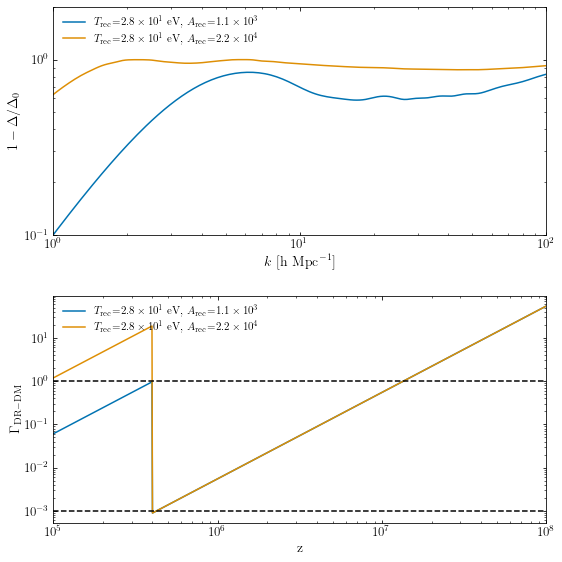

In [13]:
# # plot interpolation between two scenarios varying recoupling strength
idx = 50
idx_add = idx + 8
idx_add = idx + 16

print(
    "Showing interpolation between points with A_rec = %.2e, T_rec = %.2e and A_rec = %.2e, T_rec = %.2e"
    % (A_rec_strong_arr[idx], T_rec_strong_arr[idx], A_rec_strong_arr[idx_add], T_rec_strong_arr[idx])
)

# Varied Recoupling Strength Plot
plot_varied_recoupling(
    T_rec_strong_arr[idx],
    T_rec_strong_arr[idx],
    A_rec_strong_arr[idx],
    A_rec_strong_arr[idx_add],
)

Showing interpolation between points with A_rec = 4.33e+02, T_rec = 2.31e+05 and A_rec = 4.33e+02, T_rec = 4.04e+05


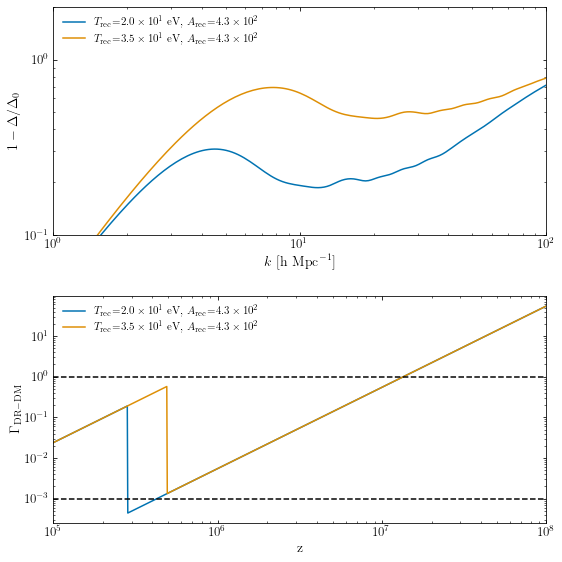

In [14]:
idx = 45
idx_add = idx + 8

print(
    "Showing interpolation between points with A_rec = %.2e, T_rec = %.2e and A_rec = %.2e, T_rec = %.2e"
    % (A_rec_strong_arr[idx], T_rec_strong_arr[idx], A_rec_strong_arr[idx], T_rec_strong_arr[idx_add])
)

# Varied Recoupling Temperature Plot
plot_varied_recoupling(
    T_rec_strong_arr[idx],
    T_rec_strong_arr[idx_add],
    A_rec_strong_arr[idx],
    A_rec_strong_arr[idx],
)

Showing interpolation between points with A_rec = 1.59e+03, T_rec = 3.76e+05 and A_rec = 6.37e+01, T_rec = 1.88e+06


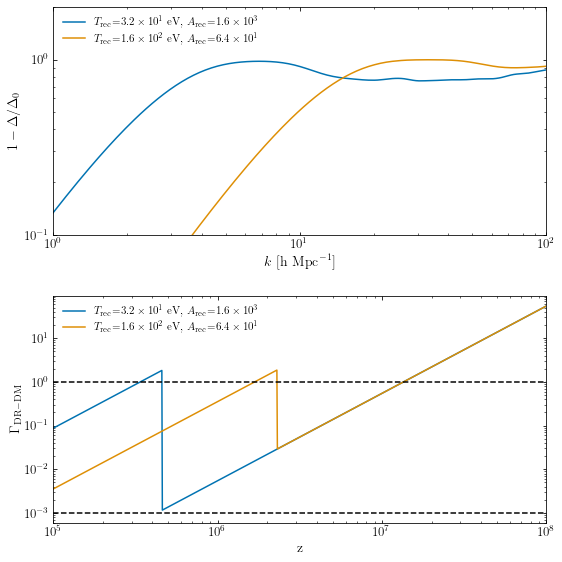

In [15]:
idx = 52

#Difference in temperature between case 1 and 2
fac = 5

T_1 = T_rec_strong_arr[idx]
T_2 = T_rec_strong_arr[idx] * fac
A_1 = A_rec_strong_arr[idx]
A_2 = A_rec_strong_arr[idx] * (1/fac)**2

print(
    "Showing interpolation between points with A_rec = %.2e, T_rec = %.2e and A_rec = %.2e, T_rec = %.2e"
    % (A_1, T_1, A_2, T_2)
)

# Same Peak $\Gamma_{\mathrm{DR-DM, peak}}$
plot_varied_recoupling(
    T_1,
    T_2,
    A_1,
    A_2,
)

### Phase transition matter power spectrum

In [16]:
def _plot_observations():

    plt.errorbar(
        dfPlanckTT["X"],
        dfPlanckTT["Y"] * (dfPlanckTT["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrTT_dimless,
        xerr=xerrTT,
        marker="o",
        ms=5,
        color="blue",
        ls="none",
        capsize=6,
        label="Planck TT",
    )

    plt.errorbar(
        dfPlanckEE["X"],
        dfPlanckEE["Y"] * (dfPlanckEE["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrEE_dimless,
        xerr=xerrEE,
        marker="o",
        ms=5,
        color="orange",
        ls="none",
        capsize=6,
        label="Planck EE",
    )

    plt.errorbar(
        dfPlanckPP["X"],
        dfPlanckPP["Y"] * (dfPlanckPP["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrPP_dimless,
        xerr=xerrPP,
        marker="o",
        ms=5,
        color="green",
        ls="none",
        capsize=6,
        label="Planck $\phi\phi$",
    )

    plt.errorbar(
        dfBOSS["X"],
        dfBOSS["Y"] * (dfBOSS["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrBOSSdimless,
        xerr=xerrBOSS,
        marker="o",
        ms=5,
        color="mediumpurple",
        ls="none",
        label=r"BOSS DR9 Ly-$\alpha$ forest",
    )

    plt.errorbar(
        dfDES["X"],
        dfDES["Y"] * (dfDES["X"] ** 3) / (2 * np.pi**2),
        yerr=yerrDESdimless,
        xerr=xerrDES,
        marker="o",
        ms=5,
        color="goldenrod",
        ls="none",
        capsize=6,
        label="DES Y1 cosmic Shear",
    )

    # No conversion because these are already dimensionless
    plt.errorbar(
        dfEDGES["X"],
        dfEDGES["Y"],
        xerr=xerrEDGES,
        yerr=yerrEDGES,
        marker="^",
        ms=10,
        color="r",
        ls="none",
        label=r"EDGES 21-cm proj.",
    )
    plt.errorbar(
        dfHERA["X"],
        dfHERA["Y"],
        xerr=xerrHERA,
        yerr=yerrHERA,
        marker="^",
        ms=10,
        color="teal",
        ls="none",
        label=r"HERA 21-cm proj.",
    )
    
def plot_observations(Tr, Ar, best_fit_a, mwarm = None, save=False):
    path = "observation_data/"

    if mwarm:

        mwarm_path = "output/warm" + mwarm + ".dat"

        try:
            dfWarm = pd.read_csv(
                mwarm_path,
                header=None,
                names=["k", "P(k)"],
                skiprows=4,
                delimiter="\s+",
            )
        except FileNotFoundError:
            print("ERROR: No file found for that warm dm mass")
            return

    plt.plot(
        dflcdm["k"],
        dflcdm["P(k)"] * (dflcdm["k"] ** 3) / (2 * np.pi**2),
        "k",
        label=r"$\Lambda_{CDM}$",
    )

    _plot_observations()

    plt.plot(
        kk,
        pk_strong_interp_n2((Tr, Ar, kk)) * (kk**3) / (2 * np.pi**2),
        "b",
        label="Kinetic Recoupling",
    )

    
    plt.plot(
        kk[-200:],
        pk_sd_interp((best_fit_a, kk[-200:])) * (kk[-200:] ** 3) / (2 * np.pi**2),
        "g-.",
        label="Single Decoupling",
    )

    # plt.plot(
    #     dfWarm["k"],
    #     dfWarm["P(k)"] * (dfWarm["k"] ** 3) / (2 * np.pi**2),
    #     "r--",
    #     label="Warm DM, m={} keV".format(mwarm.split("k")[0]),
    # )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2, 1e2)
    plt.ylim(1e-4, 6e1)

    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$\Delta^2_m(k)$")

    plt.legend()

    if save:
        plot_dir = "Figures/"
        filename = "Power_spectrum{:.1e}{:.1e}.pdf".format(Tr, Ar)
        plt.savefig(plot_dir + filename)
        plt.clf()
    # else:
    #     plt.show()

In [67]:
N_points_a = 100
a_idm_dr_arr = np.logspace(-1, 9, N_points_a)

def objective_function(a, T_rec, A_rec, kk):
    return np.sum(
        [
            (
                pk_strong_interp_n2((T_rec, A_rec, k)) * (k**3) / (2 * np.pi**2)
                - pk_sd_interp((a, k)) * (k**3) / (2 * np.pi**2)
            )
            ** 2
            for k in kk[-200:]
        ]
    )
    
def best_sd_fit_dimless(T_rec, A_rec, a_idm_dr_arr):
    """
    For a given double decoupling case, finds the best fit a_idm_dr for a single decoupling case using an l2 metric for the dimensionless power spectrum
    """
    # initial guess for a
    a0 = a_idm_dr_arr[N_points_a // 2]

    result = minimize(
        objective_function,
        a0,
        args=(T_rec, A_rec, kk),
        bounds=[(a_idm_dr_arr.min(), a_idm_dr_arr.max())],
    )

    if result.success:
        return result.x.item()
    else:
        return -1

In [68]:
best_sd_fit_dimless(T_rec_strong_arr[plot_idx],A_rec_strong_arr[plot_idx], a_idm_dr_arr)

10.70144640970178

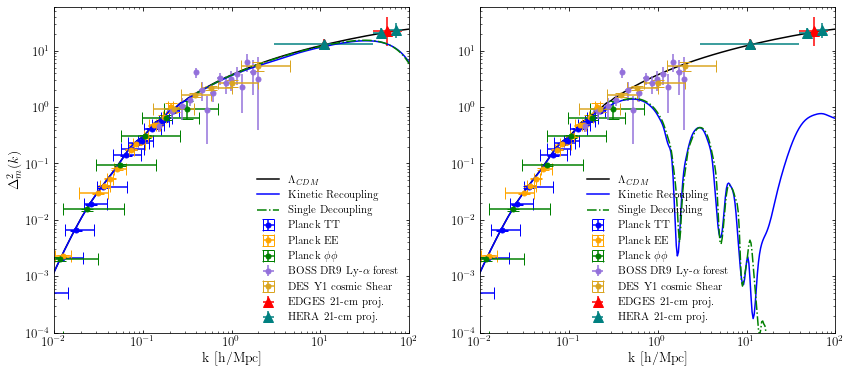

In [70]:
plot_idx = 40
plot_idx2 = 70

best_fit_a = best_sd_fit_dimless(T_rec_strong_arr[plot_idx],A_rec_strong_arr[plot_idx], a_idm_dr_arr)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

plot_observations(
    T_rec_strong_arr[plot_idx],
    A_rec_strong_arr[plot_idx],
    # best_a_dimless_arr[plot_idx - 50, plot_idx - 50],
    best_fit_a,
    # mwarm="30kev",
    mwarm="50kev",
    save=False,
)

plt.subplot(1, 2, 2)

best_fit_a = best_sd_fit_dimless(T_rec_strong_arr[plot_idx2],A_rec_strong_arr[plot_idx2], a_idm_dr_arr)

plot_observations(
    T_rec_strong_arr[plot_idx2],
    A_rec_strong_arr[plot_idx2],
    # best_a_dimless_arr[plot_idx2 - 50, plot_idx2 - 50],
    best_fit_a,
    mwarm="30kev",
    # mwarm="50kev",
    save=False,
)
plt.ylabel(None)

plt.show()

### Chi2 plots

In [18]:
#sort all relevant data by ks
constraint_ks = np.concatenate((dfDES["X"],dfBOSS["X"]))
constraint_pks = np.concatenate((dfDES["Y"], dfBOSS["Y"]))
constraint_pk_y_errs = np.concatenate((yerrDES, yerrBOSS), axis=1)
constraint_pk_x_errs = np.concatenate((xerrDES, xerrBOSS), axis=1)

constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]
constraint_pk_y_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_errs_sorted[0] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[0]))])
constraint_pk_y_errs_sorted[1] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[1]))])
constraint_pk_y_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_var_sorted[0] = constraint_pk_y_errs_sorted[0]
constraint_pk_y_var_sorted[1] = constraint_pk_y_errs_sorted[1]


constraint_pk_x_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_errs_sorted[0] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[0]))]
constraint_pk_x_errs_sorted[1] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[1]))]
constraint_pk_x_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_var_sorted[0] = constraint_pk_x_errs_sorted[0]
constraint_pk_x_var_sorted[1] = constraint_pk_x_errs_sorted[1]


### with edges + hera

constraint_ks_extended = np.concatenate((dfDES["X"], dfBOSS["X"], dfHERA["X"], dfEDGES["X"]))
# constraint_pks_extended = np.concatenate((dfDES["Y"], dfBOSS["Y"], dfHERA["Y"], dfEDGES["Y"]))
constraint_pks_extended = np.concatenate((dfDES["Y"], dfBOSS["Y"], HERA_y_dimfull, EDGES_y_dimfull))

constraint_pk_y_errs_extended = np.concatenate((yerrDES, yerrBOSS, yerrHERAdimfull, yerrEDGESdimfull), axis=1)
constraint_pk_x_errs_extended = np.concatenate((xerrDES, xerrBOSS, xerrHERA, xerrEDGES), axis=1)

constraint_ks_sorted_extended = sorted(constraint_ks_extended)
constraint_pks_sorted_extended = [x for _, x in sorted(zip(constraint_ks_extended, constraint_pks_extended))]
constraint_pk_y_errs_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_y_errs_sorted_extended[0] = np.array([x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_y_errs_extended[0]))])
constraint_pk_y_errs_sorted_extended[1] = np.array([x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_y_errs_extended[1]))])
constraint_pk_y_var_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_y_var_sorted_extended[0] = constraint_pk_y_errs_sorted_extended[0]
constraint_pk_y_var_sorted_extended[1] = constraint_pk_y_errs_sorted_extended[1]


constraint_pk_x_errs_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_x_errs_sorted_extended[0] = [x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_x_errs_extended[0]))]
constraint_pk_x_errs_sorted_extended[1] = [x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_x_errs_extended[1]))]
constraint_pk_x_var_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_x_var_sorted_extended[0] = constraint_pk_x_errs_sorted_extended[0]
constraint_pk_x_var_sorted_extended[1] = constraint_pk_x_errs_sorted_extended[1]


In [19]:
def make_constraint_chisquare(constraint_ks_sorted, constraint_pks_sorted, constraint_pk_y_var_sorted, constraint_pk_x_var_sorted):
    chi2_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            test_pks = np.array([pk_strong_interp_n2((Tr, Ar, k)) for k in constraint_ks_sorted])

            interpolating_function = interp1d(constraint_ks_sorted, test_pks, kind='cubic')
            y_interp = interpolating_function(constraint_ks_sorted)
            dx = np.gradient(constraint_ks_sorted)
            dy_dx = np.gradient(y_interp, dx)
            y_total_err = np.sqrt(constraint_pk_y_var_sorted**2 + (dy_dx * constraint_pk_x_var_sorted)**2)
            chi2 = np.sum((constraint_pks_sorted - y_interp)**2 / y_total_err**2)
            chi2_grid[i, j] = chi2
    return chi2_grid

In [20]:
chi2_grid = make_constraint_chisquare(constraint_ks_sorted, constraint_pks_sorted, constraint_pk_y_var_sorted, constraint_pk_x_var_sorted)

In [21]:
chi2_grid_extended = make_constraint_chisquare(constraint_ks_sorted_extended, constraint_pks_sorted_extended, constraint_pk_y_var_sorted_extended, constraint_pk_x_var_sorted_extended)

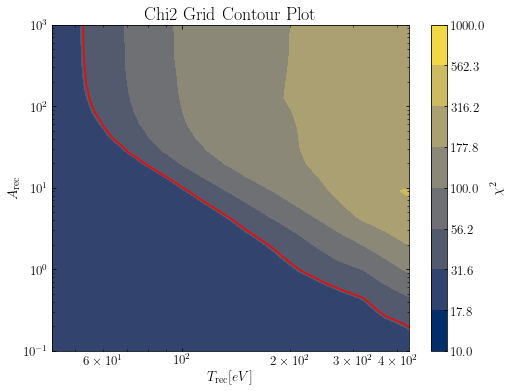

In [22]:
X, Y = np.meshgrid(T_rec_strong_arr, A_rec_strong_arr)

# Define the new grid
X_new = np.logspace(np.log10(X.min()), np.log10(X.max()), 50)  # 50 is the number of points for smoothing, adjust as needed
Y_new = np.logspace(np.log10(Y.min()), np.log10(Y.max()), 50)
X_new, Y_new = np.meshgrid(X_new, Y_new)

# Flatten your original data for the griddata function
points = np.array([X.flatten(), Y.flatten()]).T
values = chi2_grid.flatten()

# Perform the interpolation
chi2_grid_new = griddata(points, values, (X_new, Y_new), method='linear')

# Create the contour plot
plt.figure(figsize=(8, 6))
plt.contourf(X_new*ktoev, Y_new, chi2_grid_new, levels=np.logspace(1,3,9),norm=LogNorm(), cmap='cividis')

cbar = plt.colorbar()
cbar.set_label(r'$\chi^2$')
plt.contour(X_new*ktoev, Y_new, chi2_grid_new, levels=[chi2.isf(0.05, len(constraint_ks_sorted))], colors='red')

plt.xscale('log')
plt.yscale('log')
plt.xlim(5e5*ktoev, 5e6*ktoev)
plt.ylim(1e-1, 1e3)
plt.xlabel('$T_\mathrm{rec} [eV]$')
plt.ylabel('$A_\mathrm{rec}$')
plt.title('Chi2 Grid Contour Plot')
# plt.savefig('Figures/chi2_grid_contour_plot.pdf')
plt.show()

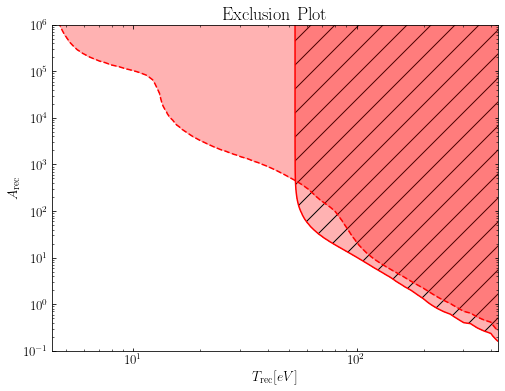

In [23]:
X, Y = np.meshgrid(T_rec_strong_arr, A_rec_strong_arr)

# Define the new grid
X_new = np.logspace(np.log10(X.min()), np.log10(X.max()), 100)  # 100 is the number of points for smoothing, adjust as needed
Y_new = np.logspace(np.log10(Y.min()), np.log10(Y.max()), 100)
X_new, Y_new = np.meshgrid(X_new, Y_new)

# Flatten your original data for the griddata function
points = np.array([X.flatten(), Y.flatten()]).T
values = chi2_grid.flatten()
values_extended = chi2_grid_extended.flatten()

# Perform the interpolation
chi2_grid_new = griddata(points, values, (X_new, Y_new), method='linear')
chi2_grid_new_extended = griddata(points, values_extended, (X_new, Y_new), method='linear')

# Create the contour plot
plt.figure(figsize=(8, 6))

# Define the levels for shading
level = chi2.isf(0.05, len(constraint_ks_sorted))
level_extended = chi2.isf(0.05, len(constraint_ks_sorted_extended))

# Create the contour plot with shading and hatching
plt.contour(X_new*ktoev, Y_new, chi2_grid_new, levels=[level, np.inf], colors='red')
plt.contour(X_new*ktoev, Y_new, chi2_grid_new_extended, levels=[level_extended, np.inf], colors='red', linestyles='dashed')

# Add shading and hatching patterns to the contour plots
plt.contourf(X_new*ktoev, Y_new, chi2_grid_new, levels=[level, np.inf], colors='red', hatches=['/'], alpha=0.3)
plt.contourf(X_new*ktoev, Y_new, chi2_grid_new_extended, levels=[level_extended, np.inf], colors='red', hatches=[''], alpha=0.3)

plt.xscale('log')
plt.yscale('log')
plt.xlim(5e4*ktoev, 5e6*ktoev)
plt.ylim(1e-1, 1e6)
plt.xlabel('$T_\mathrm{rec} [eV]$')
plt.ylabel('$A_\mathrm{rec}$')
plt.title('Exclusion Plot')
# plt.savefig('Figures/chi2_grid_contour_plot.pdf')
plt.show()

### Load Data and create interpolations (Shouldn't need to touch this)

In [24]:
# h5pydir = 'h5py_dat/'

In [25]:
# #Get data for case with no recoupling
# k = '1.0'
# data_file=h5pydir+'class_testing_no_rec.hdf5'
# with h5py.File(data_file, 'r') as f:
#     tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
#     delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
#     phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
#     theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
#     theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
#     delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
#     delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
#     phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
#     phi_dot_no_rec = phi_no_rec.derivative()
#     theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

#     theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
#     theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

#     Pks_no_rec = np.array(f['power_spectrum']['Pk'])
#     kks_no_rec = np.array(f['power_spectrum']['kk'])

#     kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
#     z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))
#     thermo_tau_data_no_rec = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))

#     rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
#     rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
#     bkg_zs_no_rec = np.array(f['background']['z'])
#     clTT_no_rec = np.array(f['cmb']['tt'])
#     ll_no_rec = np.array(f['cmb']['ell'])

#     thermo_taus_no_rec = UnivariateSpline(np.flip(z_data_no_rec), np.flip(thermo_tau_data_no_rec), **spline_pars)

#     a_data = 1/(1+z_data_no_rec)
#     a = UnivariateSpline(thermo_tau_data_no_rec, a_data, **spline_pars)
#     aprime = a.derivative()
# def conformal_H(z):
#     return aprime(thermo_taus_no_rec(z))/a(thermo_taus_no_rec(z))

In [26]:
# # Which A_recs to use for delta recoupling rate
# A_recs = [1e11, 1e12, 1e14]
# #wavenumber to use for delta recoupling rate
# k = 10

# # Get data for recouplings
# Pk_arr = []
# kappa_dot_taus_arr = []
# z_arr = []
# tau_arr = []
# rho_idr_arr = []
# rho_idm_arr = []
# a_prime_arr = []
# a_arr = []

# for A_rec in A_recs:
#     data_file = h5pydir + "class_model_data_" + "%.2e" % A_rec + ".hdf5"

#     with h5py.File(data_file, "r") as f:
#         tau_data = np.array(f["scalar"]["k=" + str(k)]["tau [Mpc]"])
#         delta_chi_data = np.array(f["scalar"]["k=" + str(k)]["delta_idm_dr"])
#         phi_data = np.array(f["scalar"]["k=" + str(k)]["phi"])
#         kappa_dot_data = np.flip(np.array(f["thermodynamics"]["dmu_idm_dr"]))
#         z_data = np.flip(np.array(f["thermodynamics"]["z"]))
#         thermo_tau_data = np.flip(np.array(f["thermodynamics"]["conf. time [Mpc]"]))
#         cx2_data = np.flip(np.array(f["thermodynamics"]["c_idm_dr^2"]))
#         theta_data = np.array(f["scalar"]["k=" + str(k)]["theta_idm_dr"])
#         theta_dr_data = np.array(f["scalar"]["k=" + str(k)]["theta_idr"])
#         psi_data = np.array(f["scalar"]["k=" + str(k)]["psi"])
#         rho_idr_data = np.array(f["background"]["(.)rho_idr"])
#         rho_idm_data = np.array(f["background"]["(.)rho_idm_dr"])
#         bkg_tau_data = np.array(f["background"]["conf. time [Mpc]"])
#         Pks = np.array(f["power_spectrum"]["Pk"])
#         kks = np.array(f["power_spectrum"]["kk"])

#     rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
#     rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

#     kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)

#     a_data = 1 / (1 + z_data)
#     a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
#     aprime = a.derivative()

#     Pk_arr.append(Pks)
#     kappa_dot_taus_arr.append(kappa_dot_taus)
#     z_arr.append(z_data)
#     tau_arr.append(tau_data)
#     rho_idr_arr.append(rho_idr)
#     rho_idm_arr.append(rho_idm)
#     a_prime_arr.append(aprime)
#     a_arr.append(a)

In [27]:
# rate_over_hubble_dict = {}
# pk_delta_dict = {}
# for i, A_rec in enumerate(A_recs):
#     rate_over_hubble =  4 / 3 * rho_idr_arr[i](tau_arr[i]) / rho_idm_arr[i](tau_arr[i]) * kappa_dot_taus_arr[i](tau_arr[i]) / (a_prime_arr[i](tau_arr[i]) / a_arr[i](tau_arr[i]))
#     rate_over_hubble_interp = interp1d(tau_arr[i], rate_over_hubble, kind="linear")
#     rate_over_hubble_dict[A_rec] = rate_over_hubble_interp

#     pk_delta = Pk_arr[i]
#     pk_delta_interp = interp1d(kks, pk_delta, kind="linear")
#     pk_delta_dict[A_rec] = pk_delta_interp

# # pickle.dump(pk_delta_dict, open("interps/pk_delta_dict.p", "wb"))
# # pickle.dump(rate_over_hubble_dict, open("interps/rate_over_hubble_dict.p", "wb"))